In [1]:
import os
os.chdir('..')

/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)



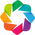

In [2]:
from jack.readers.implementations import reader_from_file
from jack.io.load import *
import tensorflow as tf
import holoviews as hv
hv.extension('bokeh')

In [3]:
ds = load_squad('data/SQuAD/dev-v1.1.json')
#ds = load_jack('../jtr/data/triviaqa/wiki-dev.json')

In [12]:
tf.reset_default_graph()
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/segm'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/segm/model_module


INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/segm/model_module


In [56]:
#fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_unsup003/'
r.load(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/experimental/assoc10_stopgrad_presegm/model_module


INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/experimental/assoc10_stopgrad_presegm/model_module


In [27]:
g = tf.get_default_graph()
address_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_probs')][0]
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]
address_probs_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_probs')][1]
frame_boundary_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][1]
segm_probs_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][1]
attention_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('question_attention_weights')][0]

start_word_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_word_score')][0]
start_ngram_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_ngram_score')][0]
start_segm_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_segm_score')][0]
frames_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frames_score')][0]

num_roles = r.shared_resources.config['num_slots']
assoc_scores = [[op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_' + str(i))][0] for i in range(num_roles)]


all_scores = [start_word_score, start_ngram_score, start_segm_score, frames_score]
all_structure = [address_probs, frame_boundary, segm_probs, address_probs_q, frame_boundary_q, segm_probs_q, attention_probs]

In [28]:
from jack.core.tensorport import Ports
from jack.readers.extractive_qa.shared import XQAPorts

answer_span_tensor = r.model_module.tensors[XQAPorts.span_prediction]


def process(index):
    ex = ds[index]
    batch = r.input_module([ex[0]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]
    question = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]
    tensors = r.session.run(all_scores + all_structure + [answer_span_tensor] + assoc_scores, feed_dict=r.model_module.convert_to_feed_dict(batch))
    ws, ns, ss, fs, ap, fp, wp, apq, fpq, wpq, attnq, answer_span = tensors[:12]
    
    doc_idx = answer_span[0, 0]

    return {
        'question_ws': [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]],
        'support_ws': [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][doc_idx]],
        's_word': ws[doc_idx], 
        's_ngram': ns[doc_idx],
        's_segm': ss[doc_idx], 
        's_frame': fs[doc_idx],
        's_assoc': sum(tensors[12:])[doc_idx] / num_roles,
        'p_slot': ap[doc_idx], 
        'p_frame': fp[doc_idx], 
        'p_segm': wp[doc_idx],
        'p_slot_q': apq[0], 
        'p_frame_q': fpq[0], 
        'p_segm_q': wpq[0],
        'p_attn_q': attnq[0],
        'question': ex[0].question,
        'answers': ex[1],
        'predicted_span': answer_span[0,1:],
    }
        
    
def idxstrseq(l):
    return [w + '   ' + str(i) for i, w in enumerate(l)]

In [57]:
import random

index = random.randint(0, len(ds) - 1)
#index = 7716  # good score example
#index=7716

data = process(index)
print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

In what venue did Super Bowl XIX take place?
Stanford Stadium [73 74]
{'Stanford Stadium'}


In [58]:
%%opts HeatMap.S [tools=['hover'] colorbar=False width=10*len(data['support_ws'])+50 toolbar='above' xrotation=90 show_title=False]
%%opts HeatMap.S.Segments [height=200] (cmap='Reds')
%%opts HeatMap.S.Scores [height=220]
%%opts HeatMap.S.Assoc [height=220] (cmap='Reds')
%%opts HeatMap.Q [tools=['hover'] colorbar=False width=15*len(data['question_ws'])+50 toolbar='above' xrotation=90 show_title=False] (cmap='Reds')
%%opts HeatMap.Q.Segments [height=200]
%%opts HeatMap.Q.Assoc [height=220]

import numpy as np


def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)


hm_scores = hv.HeatMap((idxstrseq(data['support_ws']), ['w', 'n', 'p', 'c', 'r'],
                        norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 0))),
                       group='S', label='Scores', kdims=['Tokens', 'Scores'])

q_strucutre_values = np.transpose(np.concatenate([data['p_attn_q'], data['p_segm_q'], data['p_frame_q'] * data['p_segm_q']], 1))
hm_question = hv.HeatMap((idxstrseq(data['question_ws']), list(range(q_strucutre_values.shape[0])), q_strucutre_values),
                       group='Q', label='Segments', kdims=['Tokens', 'Probs'])


strucutre_values = np.transpose(np.concatenate([data['p_segm'], data['p_segm'] * data['p_frame']], 1))
hm_support = hv.HeatMap((idxstrseq(data['support_ws']), list(range(strucutre_values.shape[0])), strucutre_values),
                       group='S', label='Segments', kdims=['Tokens', 'Probs'])

hm_assoc = hv.HeatMap((idxstrseq(data['support_ws']), list(range(data['p_slot'].shape[1])), np.transpose(data['p_slot'])),
                       group='S', label='Assoc', kdims=['Tokens', 'Probs'])
    
(hm_scores + hm_question + hm_support + hm_assoc).cols(1)

In what venue did Super Bowl XIX take place?
Stanford Stadium [73 74]
{'Stanford Stadium'}


/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Layout
   .S.Scores   :HeatMap   [Tokens,Scores]   (z)
   .Q.Segments :HeatMap   [Tokens,Probs]   (z)
   .S.Segments :HeatMap   [Tokens,Probs]   (z)
   .S.Assoc    :HeatMap   [Tokens,Probs]   (z)

In [120]:
np.median(data['s_frame'], 0, keepdims=True)

array([0.11656535], dtype=float32)

In [148]:
(np.max(data['s_frame'], 0, keepdims=True) - np.min(data['s_frame'], 0, keepdims=True)) / 2

array([ 2.12374926], dtype=float32)

In [14]:
g = tf.get_default_graph()
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
#frame_attn = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_attn')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

In [6]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp, fattn = r.session.run([frame_boundary, segm_probs, frame_attn], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))

#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
sns.heatmap(np.transpose(np.concatenate([fattn[0], rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

3890


NameError: name 'frame_attn' is not defined

1415


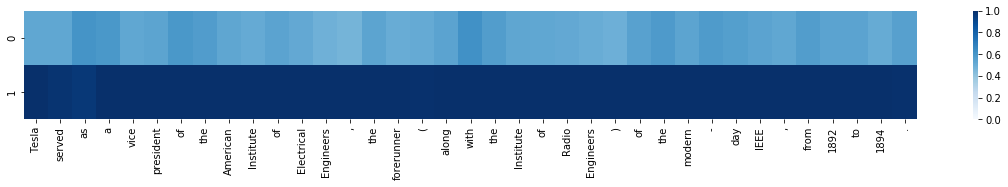

In [20]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp = r.session.run([frame_boundary, segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))

#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
sns.heatmap(np.transpose(np.concatenate([rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

In [255]:
from collections import defaultdict

start_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
end_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
phrases_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
for i in range(100):
    index = random.randint(0, len(ds) - 1)
    batch = r.input_module([q for q, a in ds[index:index + 1]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]
    start_word = 0
    ap, rp, wp = r.session.run([address_probs, frame_boundary, segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
    for j, w in enumerate(words):
        for s in range(r.shared_resources.config['num_slots']):
            if ap[0, j, s] > 0.8 and wp[0, j, 0] > 0.5:
                start_word_per_slot[s][words[start_word]] += 1
                end_word_per_slot[s][w] += 1
                phrases_per_slot[s][" ".join(words[start_word:j+1])] += 1
        if wp[0, j, 0] > 0.5 and j+1 < len(words):
            start_word = j+1
                


In [265]:
for i, ps in enumerate(phrases_per_slot):
    print()
    print(', '.join(random.sample([p for p, n in ps.items()], 20)))

    #print(i)
    #for p, n in sorted(ps.items(), key=lambda x: -x[1])[:5]:
     #   print(p, n)
        

#phrases_per_slot[0]


on the condition, earn, conditions, for 485 yards, precedent, eight appearances, changes, three, packet, Some examples, a large collection, following, of accounts, produced, pace, ( 31 receptions, with a standard, inscriptions, just, reprised

ultimate, killed, modified, reluctant, a new, respected, cause, posed, propose, and asked, traditionally, motivated, potentially, the most, and the major, the disputed, of the new, , not, suspended, became

by the Bonn council, Greg Olsen, rich Mongol, of Amida Nyorai, university, at Leipzig, Jerricho Cotchery, of Milan Ludovico Sforza, Wales, Here, in Worms, from umbilical cords, by John Forster, with the church, to the Saxon, that Tesla, Johnson 's, in Schmidberger v Austria, St. Hyacinth 's Church, in Commission v France

routed, congregation, to the standard theory, goes, at the request, rebelled, to the difference, strictly, stationary, settled, for Luther, from his daily labour, leave, to favor, transported, launched, to the mesophyll, as 

6115


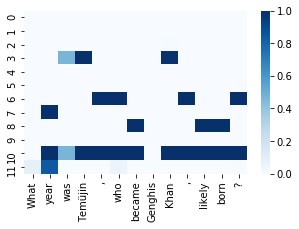

In [162]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
#index = 9154 # Where
print(index)
batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]

fig, axs = plt.subplots(nrows=1, figsize=(5,3))
ap, attn, wp = r.session.run([address_probs_q, attention_probs, segm_probs_q], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

sns.heatmap(np.transpose(np.concatenate([ap[0]*wp[0], wp[0], attn[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmin=0.0)#, ax=axs[0])


In [203]:
from collections import defaultdict

start_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
end_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
phrases_per_slot = [[] for _ in range(r.shared_resources.config['num_slots'])]
attn_heads_per_slot = [[] for _ in range(r.shared_resources.config['num_slots'])]
for i in range(1000):
    index = random.randint(0, len(ds) - 1)
    batch = r.input_module([q for q, a in ds[index:index + 1]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]
    start_word = 0
    ap, attn, wp = r.session.run([address_probs_q, attention_probs, segm_probs_q], feed_dict=r.model_module.convert_to_feed_dict(batch))
    max_attn = np.max(attn, )
    for j, w in enumerate(words):
        for s in range(r.shared_resources.config['num_slots']):
            if ap[0, j, s] > 0.5 and wp[0, j, 0] > 0.8:
                start_word_per_slot[s][words[start_word]] += 1
                end_word_per_slot[s][w] += 1
                phrases_per_slot[s].append(" ".join(words[start_word:j+1]))
                if attn[0, j] == max_attn:
                    attn_heads_per_slot[s].append(" ".join(words[start_word:j+1]))
        if wp[0, j, 0] > 0.8 and j+1 < len(words):
            start_word = j+1


In [212]:
from collections import Counter

for i, ps in enumerate(attn_heads_per_slot):
    ct = Counter()
    for p in ps:
        ct[p] += 1

    print(i, '&', ', '.join("%s (%d)" % (p, n) for p, n in sorted(ct.items(), key=lambda x: -x[1])[:5]), ' &  \\\\')
    

0 & How much (10), What percentage (6), , what percentage (2), cost (2), What type of actions (2)  &  \\
1 & term (3), called (3), What happened (3), do (2), acronym (2)  &  \\
2 & Where (3), What network (2), what chemicals (1), the system (1), What notable private school (1)  &  \\
3 & Why (12), From where (1), to which sport (1), from what sea (1), the premise (1)  &  \\
4 & How (28), What (7), What group (4), What city (2), On where (2)  &  \\
5 & What (81), Where (25), , what (10), Which (1), , which law (1)  &  \\
6 & What type of regime (2), program (2), What area (2), At what point (2), approach (1)  &  \\
7 & When (68), In what year (10), What year (6), How long (4), In which year (3)  &  \\
8 & Who (89), the name (10), What country (6), company (4), name (4)  &  \\
9 & Which languages (2), many (2), To whom (1), Which entities (1), the population (1)  &  \\


8087


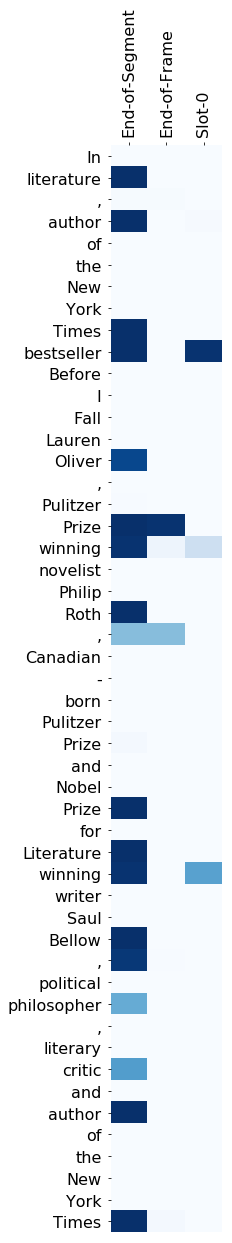

In [94]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)

sns.set_context("paper", font_scale=2, rc={"axes.labelposition": "top"})


batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp, ap = r.session.run([frame_boundary.outputs[0], segm_probs.outputs[0], address_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(2 + ap.shape[2] // 2,20))


#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
g = sns.heatmap(np.concatenate([wp[0], rp[0] * wp[0], ap[0]], 1)[:50], 
                yticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0, cbar=False)

g.set_xticklabels(['End-of-Segment', 'End-of-Frame'] + ['Slot-%d' % i for i in range(ap.shape[2])], rotation=90)
g.xaxis.tick_top()
g.xaxis.set_label_position('top')


#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

In [90]:
?sns.heatmap

In [86]:
ap.shape

(1, 142, 10)

(array([[ 0.,  2.,  1.,  3.],
        [ 2.,  0.,  4.,  2.],
        [ 4.,  1.,  5.,  1.]]), 25.0)

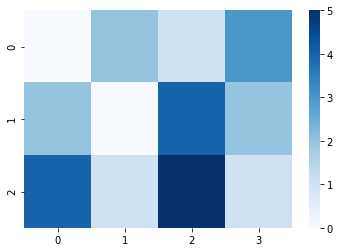

In [38]:
A = np.array([[0.0,2,1,3], [2, 0, 4, 2], [4, 1, 5, 1]])
P = np.ones_like(A) * 1.0 / max(A.shape[0], A.shape[1])
sns.heatmap(A, cmap="Blues")
A, np.sum(A)

(array([  9.99724430e-01,   3.18881637e-07,   9.99936328e-01,
          9.99999681e-01]), array([ 1.        ,  0.99966076,  1.        ]))

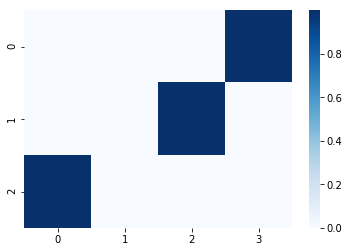

In [393]:
B = P * A
W = B * B / np.sum(A, axis=0, keepdims=True) / np.sum(A, axis=1, keepdims=True)
P = W / np.maximum(np.sum(W, 0, keepdims=True), np.sum(W, 1, keepdims=True))
sns.heatmap(P, cmap="Blues")
np.sum(P, axis=0), np.sum(P, axis=1)

(array([ 0.61363636,  0.42424242,  0.95454545,  0.84090909]),
 array([ 0.93333333,  0.9       ,  1.        ]))

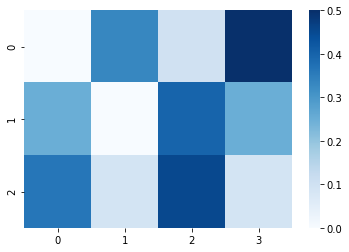

In [385]:
W = P * A
#W = B * B / np.sum(A, axis=0, keepdims=True) / np.sum(A, axis=1, keepdims=True)
P = W / np.maximum(np.sum(W, 0, keepdims=True), np.sum(W, 1, keepdims=True))
sns.heatmap(P, cmap="Blues")
np.sum(P, axis=0), np.sum(P, axis=1)

In [266]:
np.maximum(np.sum(A, 0, keepdims=True), np.sum(A, 1, keepdims=True))

array([[  9.,   8.,  11.,   9.],
       [ 20.,  20.,  20.,  20.],
       [ 11.,  11.,  11.,  11.]])

In [263]:
A1

array([[ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.25663196,  0.        ,  0.74336804,  0.        ]])

In [39]:
import tensorflow as tf

In [58]:
A = np.array([[[0.0,2,1,3],
              [2, 0, 4, 2],
              [4, 1, 5, 1],
              [40, 10, 50, 10]],
              [[0.0,2,1,3],
              [2, 0, 4, 2],
              [4, 1, 5, 1],
              [40, 10, 50, 10]]])

r.model_module.tf_session.run(tf.matrix_band_part(A, -1, 0) * (1.0 - tf.expand_dims(tf.eye(tf.shape(A)[1], tf.shape(A)[2], dtype=tf.float64), 0)))

array([[[  0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.],
        [  4.,   1.,   0.,   0.],
        [ 40.,  10.,  50.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.],
        [  4.,   1.,   0.,   0.],
        [ 40.,  10.,  50.,   0.]]])

In [3]:
ds = load_squad('data/SQuAD/dev-v1.1.json')

In [50]:
tf.reset_default_graph()
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/model_module


In [133]:
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/'
r.load(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/model_module


In [122]:
g = tf.get_default_graph()
address_probs = [op for op in g.get_operations() if op.name.endswith('depth_prob')][1]
segm_probs = [op for op in g.get_operations() if op.name.endswith('segm_probs')][1]
pop_probs = [op for op in g.get_operations() if op.name.endswith('pop_probs')][1]
push_probs = [op for op in g.get_operations() if op.name.endswith('push_probs')][1]

3750


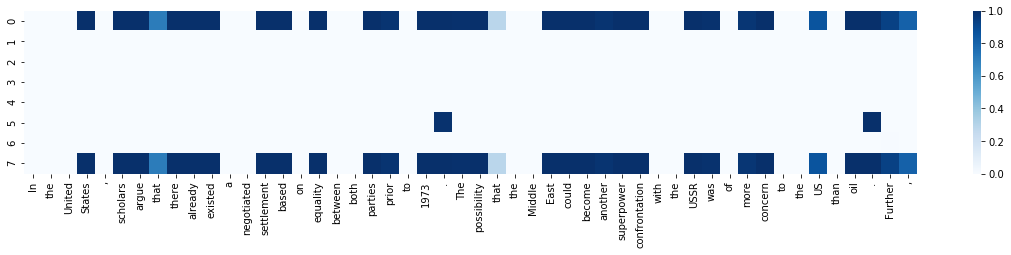

In [178]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ap, wp, op, up = r.session.run([address_probs.outputs[0], segm_probs.outputs[0], pop_probs.outputs[0], push_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

hard=False

if hard:
    op, up, wp = np.round(op), np.round(up), np.round(wp)

op *= wp
up *= np.concatenate([np.ones([1, 1, 1]), wp[:, :-1]], 1) * (1-op)

fig, axs = plt.subplots(nrows=1, figsize=(20,3))
sns.heatmap(np.transpose(np.concatenate([ap[0] * wp[0],
                                         np.zeros_like(op[0]),
                                         op[0],
                                         up[0],
                                         wp[0]], 1)[:50]),
            xticklabels=words[:50], cmap="Blues", vmin=0.0, vmax=1.0)#, ax=axs[0])
depth = ap.shape[2]
if hard:
    s = ['->']
    d = 0
    for i, w in enumerate(words):
        if up[0, i, 0] > 0.8 and d < depth - 1:
            d = 1
            if not s[-1].startswith('\n'):
                s.append('\n' + '    ' * d + '->')
        if s[-1] == '\n':
            s[-1] += '    ' * d + '->'
        s.append(w)
        if op[0, i, 0] > 0.8:
            #s.append('}')
            if d == 0:
                s.append('\n----------------------------------------------------------------------------------------------------------')
            else:
                d -= 1
            s.append('\n')
        elif wp[0, i, 0] > 0.8:
            s.append('|')
    print(" ".join(s))

In [320]:
address_probs = [list(op for op in g.get_operations() if op.name.endswith('address_probs' + str(i)))[1]
                 for i in range(r.shared_resources.config['num_layers'])]

3809


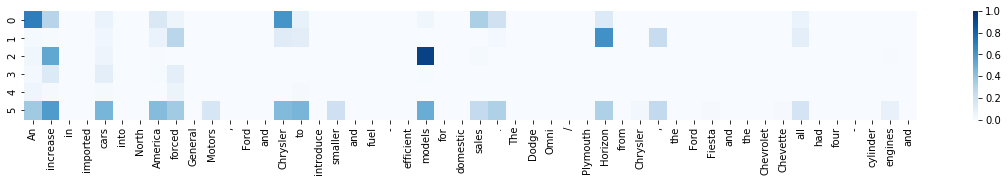

In [328]:
level = 1

index = random.randint(0, len(ds) - 1)
print(index)

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ps = r.session.run([p.outputs[0] for p in segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
ap = r.session.run([p.outputs[0] for p in address_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
ps = np.cumprod(np.concatenate(ps, 2), 2)
#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
#sns.heatmap(np.transpose(np.concatenate(ps, 2)[0, :50, ::-1]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
sns.heatmap(np.transpose(np.concatenate([ap[level], ps[:,:,level:level+1]], 2)[0, :50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)

In [5]:
import spacy
nlp = spacy.load("en")
ds = load_squad('data/SQuAD/dev-v1.1.json')

In [28]:
tf.reset_default_graph()
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/ngram'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/ngram/model_module


In [6]:
import random

total = len(da)
num_correct = 0

for index in range(total):
    a = r([q for q, a in ds[index:index + 1]])[0][0]

    support = nlp(ds[index][0].support[0])
    support_sentences = list(support.sents)

    def sentence_idx(idx):
        for i, s in enumerate(support_sentences):
            if s.start_char <= idx and s.end_char >= idx:
                return i

    if sentence_idx(a.span[0]) == sentence_idx(ds[index][1][0].span[0]):
        num_correct += 1

num_correct / total

0.759

In [ ]:
# ngram:           60.9
# segm:            62.0
# frame:           75.0
# assoc10:         
# assoc10_unsup01: 76.2
#
# bilstm 256:      69.0

In [32]:
from jack.util.preprocessing import nlp_preprocess
from jack.util.vocab import Vocab

vocab = Vocab()

def load_conll_srl(path):
    sentences = list()
    all_srls = list()
    srls = None
    current_labels = None
    with open(path, 'r') as f:
        for l in f:
            if l.startswith('#'):
                continue
            if l.strip():
                split = [s for s in l.split(' ') if s]
                if srls is None:
                    srls = [[list()] for _ in range(len(split) - 12)]
                    current_labels = ['*' for _ in range(len(split) - 12)]
                    sentences.append([])
                
                words = nlp_preprocess(split[3].replace('/.', '.'), vocab)[0]
                sentences[-1].extend(words)
                
                for i, s in enumerate(split[11:-1]):
                    if s.startswith("("):
                        current_labels[i] = s[1:s.index('*')]
                        if srls[i][-1]:
                            srls[i].append([])
                    srls[i][-1].extend([current_labels[i]] * len(words))
                    if s.endswith(")"):
                        srls[i].append([])
                        current_labels[i] = '*'
            else:
                all_srls.append(srls)
                srls = None
    for i in range(len(sentences)):
        sentences[i] = ' '.join(sentences[i])
    return sentences, all_srls
    

In [33]:
sentences, srls = load_conll_srl('/run/media/diwe01/Data3/ontonotes-release-5.0/conll-formatted-ontonotes-5.0-12/conll-formatted-ontonotes-5.0/data/development/data/english/annotations/bc/cnn/00/cnn_0000.gold_conll')

(48, 0.2222222222222222)

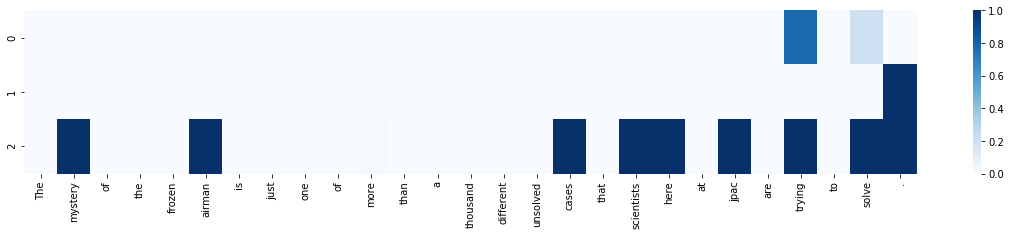

In [34]:
from jack.core.data_structures import QASetting
import numpy as np
from jack.core.tensorport import Ports

idx = random.randint(0, len(sentences)-1)

qa = QASetting('', [sentences[idx]])

batch = r.input_module([qa])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ap, rp, wp = r.session.run([address_probs.outputs[0], frame_boundary.outputs[0], segm_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

spans = set()
roles = dict()
last = 0
for i, v in enumerate(wp[0,:,0]):
    if v > 0.8:
        spans.add((last, i))
        last = i + 1
        

possible_spans = set()
for srl in srls[idx]:
    offset = 0
    for s in srl:
        possible_spans.add((offset, offset + len(s) - 1))
        offset += len(s)
        

fig, axs = plt.subplots(nrows=1, figsize=(20,3))
sns.heatmap(np.transpose(np.concatenate([ap[0], rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmin=0.0, vmax=1.0)#, ax=axs[0])

idx, len(spans.intersection(possible_spans)) / len(spans)

In [35]:
possible_spans, spans

({(0, 3),
  (0, 5),
  (0, 16),
  (0, 17),
  (0, 21),
  (4, 4),
  (5, 5),
  (6, 6),
  (6, 26),
  (7, 25),
  (17, 17),
  (18, 21),
  (22, 22),
  (22, 24),
  (23, 23),
  (23, 26),
  (24, 25),
  (25, 25),
  (26, 26)},
 {(0, 1),
  (2, 5),
  (6, 16),
  (17, 18),
  (19, 19),
  (20, 21),
  (22, 23),
  (24, 25),
  (26, 26)})

In [172]:
len(spans.intersection(possible_spans)) / len(spans)

0.7333333333333333

In [150]:
start = 0
end = 30
scores = norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 1))[start:end]


In [154]:
%%opts HeatMap.S [fontsize={'ticks': 12, 'title': 12, 'ylabel': 12, 'xlabel': 12} colorbar=False height=20*(end-start)+50 toolbar='above' show_title=False]
%%opts HeatMap.S.Segments [height=240] (cmap='Reds')
%%opts HeatMap.S.Scores [width=300]
%%opts HeatMap.S.Assoc [height=220] (cmap='Reds')

import numpy as np

def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

hm_scores = hv.HeatMap((['w', 'n', 'p', 'c', 'r'], idxstrseq(data['support_ws'])[start:end], scores),
                       group='S', label='Scores', kdims=['Scores', 'Tokens'])

hm_scores

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Stewart', 'Darian Stewart'}


:HeatMap   [Scores,Tokens]   (z)

# Example for Paper

In [13]:
import random
import numpy as np

index = 727
data = process(index)
print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

start = 0
end = 30
scores = norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 0))

scale = 4

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Darian Stewart', 'Stewart'}


In [14]:
%%opts HeatMap.S1 [xaxis=None height=int(scale*160) fontsize={'ticks': int(scale*20), 'ylabel': int(scale*16)} colorbar=False width=int(scale*40*(end-start)+50) toolbar='above' xrotation=90 show_title=False] (cmap='gray_r')
%%opts HeatMap.S2 [height=int(scale*400) fontsize={'ticks': int(scale*20), 'ylabel': int(scale*16), 'xlabel': int(scale*20)} colorbar=False width=int(scale*40*(end-start)+50) toolbar='above' xrotation=90 show_title=False] (cmap='gray_r')


import numpy as np


print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)


hm_scores1 = hv.HeatMap((range(len(data['support_ws'])), ['w', 'n', 'p', 'c', 'r'], scores),
                        group='S1', label='Scores', kdims=['Tokens', 'Scores'])


hm_scores2 = hv.HeatMap((idxstrseq(data['support_ws'])[start:end], ['w', 'n', 'p'], scores[:3, start:end]),
                        group='S2', label='Scores', kdims=['Tokens', 'Scores'])
(hm_scores1 + hm_scores2).cols(1)

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Darian Stewart', 'Stewart'}


/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Layout
   .S1.Scores :HeatMap   [Tokens,Scores]   (z)
   .S2.Scores :HeatMap   [Tokens,Scores]   (z)

In [155]:
labels = ['1/1k', '3/3k', '10/10k', '30/30k', '100/100k', '300/Full']
baseline = [44.3, 50.5, 55.5, 61.9, 68.1, 76.9]
task = [51.8, 55.8, 60.1, 65.0, 70.7, 78.1]
knowledge = [52.4, 57.9, 62.4, 66.6, 71.3, 78.8]

In [160]:
%%opts Curve [height=600 fontsize={'ticks': 20, 'ylabel': 20, 'xlabel': 20, 'legend': 20} width=1000 toolbar='above' show_title=False]

c1 = hv.Curve((labels, baseline),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="ESIM")
c2 = hv.Curve((labels, task),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="+ Task Input")

c3 = hv.Curve((labels, knowledge),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="+ ConceptNet")

c1 * c2 * c3

/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Overlay
   .Curve.ESIM            :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)
   .Curve.Plus_Task_Input :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)
   .Curve.Plus_ConceptNet :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)

In [158]:
hv.help(hv.Curve)

Curve

Online example: http://holoviews.org/reference/elements/bokeh/Curve.html

-------------
Style Options
-------------

	alpha, color, hover_alpha, hover_color, hover_line_alpha, hover_line_color, line_alpha, line_cap, line_color, line_dash, line_join, line_width, muted_alpha, muted_color, muted_line_alpha, muted_line_color, nonselection_alpha, nonselection_color, nonselection_line_alpha, nonselection_line_color, selection_alpha, selection_color, selection_line_alpha, selection_line_color

(Consult bokeh's documentation for more information.)

------------
Plot Options
------------

The plot options are the parameters of the plotting class:

Parameters of 'CurvePlot'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                                 Value                         Type         Bounds     Mode  

apply_extents                         True         